# South Africa

S5P NO2: Original resolution: 7km x 7km. Improved resolution: 1km x 1km.

Predictors used at the moment:
* DEM

In [167]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold
import statistics 

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)# South Africa

from utils_carles import polygrid, export_geotiff, percs_landuse, upscale_mean_tiff, extract_points_from_raster,recpolygrid

In [168]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [169]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

In [170]:
# CHANGE THIS VALUE to True IF PRE-PROCESSING NEEDS TO BE DONE
preproc = True

## Pre-processing (training data)

Prepare CAMS data. I do not do any temporal adjustment because we're using DEM for now. EPSG=4326.

In [175]:
# Read S5P NO2
s5p_train_dir = DATA_DIR/AOIS[0]/'sentinel5P'
#s5p_products = ['NO2','UV_AEROSOL_INDEX']
s5p_products = sorted(os.listdir(s5p_train_dir))

s5p_eops = [load_tiffs(s5p_train_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2':s5p_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL':s5p_eops[1].meta_info['Names']},
                  timestamp=s5p_eops[0].timestamp,
                  bbox=s5p_eops[0].bbox)
del s5p_eops
s5p_eop


EOPatch(
  data: {
    NO2: numpy.ndarray(shape=(100, 70, 77, 2), dtype=float32)
    UV_AEROSOL_INDEX: numpy.ndarray(shape=(85, 71, 77, 2), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_NO2: ['S5P_NO2__RPRO_L2_day2141_T10.tif', ..., 'S5P_NO2__RPRO_L2_day2232_T12.tif'], length=100
    Names_UV_AEROSOL: ['S5P_AER_AI_OFFL_L2_day2168_T10.tif', ..., 'S5P_AER_AI_OFFL_L2_day2232_T12.tif'], length=85
  }
  bbox: BBox(((26.677331470947365, -27.758826442871097), (31.51909147094736, -23.35722644287111)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 10, 0), ..., datetime.datetime(1900, 5, 12, 12, 0)], length=100
)

In [176]:
## Set no valid data to np.nan

s5p_eop.data['NO2'][s5p_eop.data['NO2'] == NO_DATA_VALUE] = np.nan
s5p_eop.data['UV_AEROSOL_INDEX'][s5p_eop.data['UV_AEROSOL_INDEX'] == NO_DATA_VALUE] = np.nan


## Use Qa band to reduce noisy observations
min_q_a = 50

for s5pp in s5p_products:
    s5p_eop.data[s5pp][..., 0][s5p_eop.data[s5pp][..., 1] <= min_q_a] = np.nan

In [177]:
### Extract NO2 bands after filitering them 

## location of exported tiff
filtered_s5p_products = ['filtered_NO2', 'filtered_UV_AEROSOL_INDEX']

filtered_S5P_location = str(DATA_DIR/AOIS[0])+'/filtered_sentinel5P'
if not os.path.isdir(filtered_S5P_location):
    os.makedirs(filtered_S5P_location)
    for i in filtered_s5p_products:
        os.mkdir(filtered_S5P_location + '/' + i)


        
## Task to add the filtered NO2 band 
add_NO2 = (FeatureType.DATA_TIMELESS, 'NO2')
add_s5p_NO2 = AddFeature(add_NO2)

## Task to export the merged tiff (mean of daily measurments)
export_tiff = ExportToTiff((FeatureType.DATA_TIMELESS, 'NO2'))


t,x,y,b = s5p_eop.data['NO2'].shape

for index in range(t):
    NO2_array = s5p_eop.data['NO2'][index][...,0]
    # add dimension
    NO2_array= np.expand_dims(NO2_array, axis=-1)
    
    ## execute the add task
    add_s5p_NO2.execute(s5p_eop,NO2_array)
    
    ## tiff name (filtered NO2)
    tiffname = s5p_eop.meta_info['Names_NO2'][index]
    
    ## export the tiff (filtered NO2)
    export_tiff.execute(s5p_eop, filename=str(filtered_S5P_location)+'/filtered_NO2'+'/'+tiffname)
    

In [223]:
## lOAD FILTERED NO2
s5p_train_dir = DATA_DIR/AOIS[0]/'filtered_sentinel5P'

s5p_eop = load_tiffs(s5p_train_dir/'filtered_NO2', (FeatureType.DATA, 'NO2'), offset=OFFSET) 
           

In [224]:
s5p_eop

EOPatch(
  data: {
    NO2: numpy.ndarray(shape=(100, 70, 77, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names: ['S5P_NO2__RPRO_L2_day2141_T10.tif', ..., 'S5P_NO2__RPRO_L2_day2232_T12.tif'], length=100
  }
  bbox: BBox(((26.677331470947365, -27.758826442871097), (31.51909147094736, -23.35722644287111)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 10, 0), ..., datetime.datetime(1900, 5, 12, 12, 0)], length=100
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


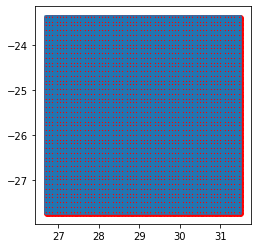

In [180]:
# Create rectangular grid for pixels corresponding to NO2
bounds = list(s5p_eop.bbox)
xres = (bounds[2]-bounds[0])/s5p_eop.data["NO2"].shape[1]
yres = (bounds[3]-bounds[1])/s5p_eop.data["NO2"].shape[2]
bounds = geometry.box(bounds[0], bounds[1], bounds[2], bounds[3])
bounds = gpd.GeoDataFrame({"id":1,"geometry":[bounds]}, crs="EPSG:4326")
s5p_grid = recpolygrid(bounds, xres,yres, 4326)
s5p_centroids = gpd.GeoDataFrame(geometry= s5p_grid.centroid)
p = s5p_grid.boundary.plot()
s5p_centroids.plot(ax=p, color='red')
plt.show()

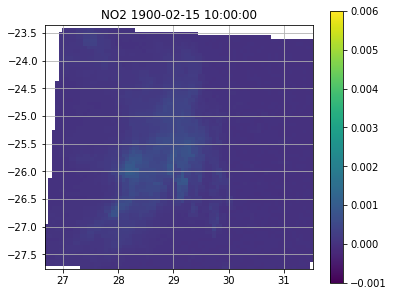

In [181]:
# Draw a sample
fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=s5p_eop, 
                 feature=(FeatureType.DATA, 'NO2'),
                 time_idx=5, 
                 vmin=-0.001, vmax=0.006)
fig.colorbar(fh, ax=ax);

Prepare DEM data at 1km resolution to make computations easier. EPSG=4326

In [186]:
# Resampling DEM to 1 Km with the same bounding box of NO2 to make it manageable. Use custom function to use mean.
if preproc:
    # Get resampling dimensions
    target_size = bbox_to_dimensions(s5p_eop.bbox, 1000)

    # Sampling files to 40 km using bilinear interpolaiton
    path_in = Path(str(DATA_DIR/AOIS[0])+'/DEM/COP_DSM_south_africa_GLO-30.tif')
    #path_out = str(DATA_DIR/AOIS[0])+'/DEM/NO2_DEM_1km.tif'
    filename = 'NO2_DEM_1km.tif'
    upscale_mean_tiff(path_in, filename, target_size)

Now compute mean DEM per CAMS pixel

In [191]:
# Read resampled DEM at 1 km
if preproc:
    dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
    dem_train_eop = load_tiffs(datapath=dem_train_dir,
                              feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                              filename='NO2_DEM_1km.tif',
                            no_data_value=128)
    
    # Perform zonal statistics - mean altitude per CAMS pixel
    src = rio.open(str(dem_train_dir) + '/NO2_DEM_1km.tif')
    affine = src.transform
    array = dem_train_eop.data_timeless['DEM']
    array = array[:, :, 0] # Remove one dimension
    dem_grid = s5p_grid
    zstats = zonal_stats(dem_grid, array, affine=affine, stats="mean", nodata=np.nan)
    vals = []
    for index, value in enumerate(zstats):
        vals.append(value['mean'])
    dem_grid['elevation'] = vals

In [192]:
# Now we can rasterize
if preproc:
    minx, miny, maxx, maxy = s5p_grid.geometry.total_bounds
    sizey = round((maxy-miny)/yres)
    sizex = round((maxx-minx)/xres)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(dem_grid.geometry, dem_grid['elevation']))
    dem = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    dem
    export_geotiff(str(dem_train_dir) + '/DEM_NO2.tif', dem, transform, 4326)

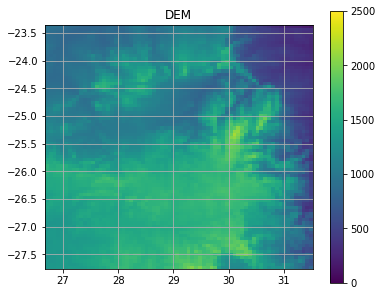

In [193]:
# Read and visualize
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                           filename='DEM_NO2.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_train_eop, 
                 feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                 time_idx=None, 
                 vmin=0, vmax=2500)
fig.colorbar(fh, ax=ax);

# Data merging

Now that everything is in the same format, we need to create our training datasets to start modelling.

In [194]:
# Extract DEM
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
if preproc:
    raster_path = [(str(dem_train_dir) + '/DEM_NO2.tif')]
    dem_df = extract_points_from_raster(s5p_centroids, raster_path, 'DEM')
    dem_df = pd.concat(dem_df)
    dem_df = dem_df.dropna()
    dem_df = dem_df.drop('raster', 1)
    

In [197]:
# Extract NO2

s5p_train_dir = DATA_DIR/AOIS[0]/'filtered_sentinel5P'

s5p_paths = glob.glob(str(s5p_train_dir) + '/filtered_NO2/*.tif')[0:150]
s5p_df = extract_points_from_raster(s5p_centroids, s5p_paths, 'NO2')
s5p_df = pd.concat(s5p_df)

s5p_df['raster'] = s5p_df['raster'].replace(str(s5p_train_dir) + '/filtered_NO2/','',regex=True)
s5p_df['date'] = s5p_df['raster'].str.slice(20, 24).astype(int)
s5p_df['hour'] = s5p_df['raster'].str.slice(26, 28).astype(int)
s5p_df['datehour'] = s5p_df['date'].astype(str) + s5p_df['hour'].astype(str)

s5p_df = s5p_df.dropna()
s5p_df = s5p_df.drop('raster', 1)

In [198]:
s5p_df

,lon,lat,NO2,date,hour,datehour
57,26.711915,-26.644136,0.000009,2141,10,214110
58,26.711915,-26.701299,-0.000003,2141,10,214110
59,26.711915,-26.758463,0.000022,2141,10,214110
60,26.711915,-26.815626,0.000022,2141,10,214110
61,26.711915,-26.872790,0.000022,2141,10,214110
...,...,...,...,...,...,...
5308,31.415339,-27.501590,0.000118,2232,12,223212
5309,31.415339,-27.558754,0.000118,2232,12,223212
5310,31.415339,-27.615917,0.000132,2232,12,223212
5311,31.415339,-27.673081,0.000087,2232,12,223212


In [199]:
# Inner join by coordinates

if preproc:
    train_df = pd.merge(s5p_df, dem_df, on=['lon', 'lat'], how='inner')

    
#write to disk
train_df.to_csv(str(DATA_DIR) + '/NO2_training_data.csv')

# Read data
train_df = pd.read_csv(str(DATA_DIR) + '/NO2_training_data.csv', index_col=0)


In [213]:
train_df = pd.read_csv(str(DATA_DIR) + '/NO2_training_data.csv', index_col=0)


## Exploratory analysis

convert unit of NO2 to molec/cm2 using the following formula: 
 * NO2 [molec/cm2] = NO2 [mol/m2] * (6.02214e+19)
 * for station data: NO2 [μg m-3] = NO2 [molec/cm2] * (1.0e-15 * 1.9125)

In [211]:
train_df['molec_NO2'] = train_df['NO2'] * (6.02214e+19)
train_df['mg_NO2'] = train_df['molec_NO2'] * (1.0e-15 * 1.9125)

Summary statistics:

In [214]:
train_df.describe()

,lon,lat,NO2,date,hour,datehour,DEM
count,436189.000000,436189.000000,436189.000000,436189.000000,436189.000000,436189.000000,436189.000000
mean,29.132505,-25.633921,0.000070,2192.660053,10.731075,219276.736408,1250.011869
std,1.356137,1.233757,0.000107,24.959065,0.661650,2495.878294,363.655968
min,26.711915,-27.730245,-0.000103,2141.000000,10.000000,214110.000000,270.906950
25%,27.956939,-26.701299,0.000016,2175.000000,10.000000,217511.000000,1014.598700
50%,29.132795,-25.672354,0.000029,2194.000000,11.000000,219410.000000,1312.842000
75%,30.308651,-24.586245,0.000074,2214.000000,11.000000,221410.000000,1548.993500
max,31.484507,-23.385808,0.002418,2232.000000,12.000000,223212.000000,2164.204800


Association of NO2 with DEM:

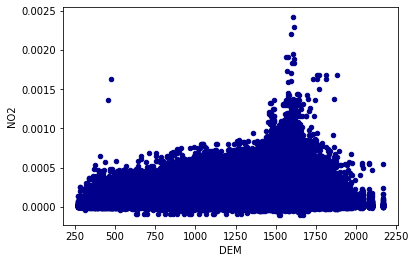

In [203]:
ax1 = train_df.plot.scatter(x='DEM', y='NO2', c='DarkBlue')

Association of NO2 with lon:

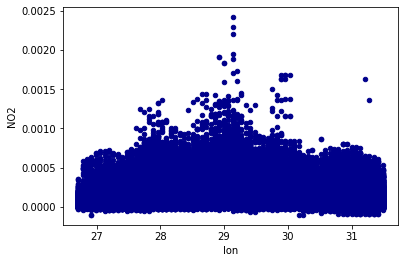

In [205]:
ax2 = train_df.plot.scatter(x='lon', y='NO2', c='DarkBlue')

Association of NO2 with lat:

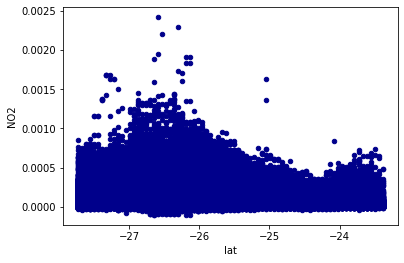

In [206]:
ax3 = train_df.plot.scatter(x='lat', y='NO2', c='DarkBlue')

Association of NO2 with hour:

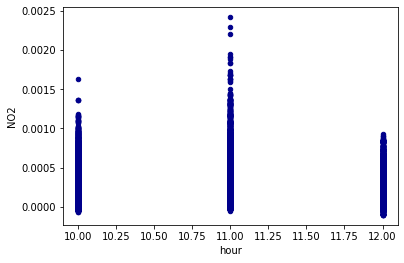

In [207]:
ax4 = train_df.plot.scatter(x='hour', y='NO2', c='DarkBlue')

Association of NO2 with date:

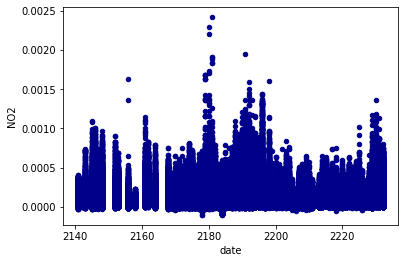

In [208]:
ax5 = train_df.plot.scatter(x='date', y='NO2', c='DarkBlue')

In [209]:
train_df

,lon,lat,NO2,date,hour,datehour,DEM
0,26.711915,-26.644136,0.000009,2141,10,214110,1467.5972
1,26.711915,-26.644136,0.000006,2141,12,214112,1467.5972
2,26.711915,-26.644136,0.000028,2143,11,214311,1467.5972
3,26.711915,-26.644136,0.000017,2146,12,214612,1467.5972
4,26.711915,-26.644136,0.000027,2148,11,214811,1467.5972
...,...,...,...,...,...,...,...
436184,31.484507,-27.730245,0.000074,2209,10,220910,827.8701
436185,31.484507,-27.730245,0.000099,2218,11,221811,827.8701
436186,31.484507,-27.730245,0.000101,2222,11,222211,827.8701
436187,28.233611,-23.385808,0.000019,2205,12,220512,970.0414


Rank correlation between predictors

In [210]:
# calculate the correlation matrix
corr = train_df.drop(['date','datehour'], axis=1).corr(method='spearman')
round(corr, 2)

,lon,lat,NO2,hour,DEM
lon,1.00,0.01,-0.03,-0.13,-0.18
lat,0.01,1.00,-0.32,-0.04,-0.60
NO2,-0.03,-0.32,1.00,0.00,0.29
hour,-0.13,-0.04,0.00,1.00,0.05
DEM,-0.18,-0.60,0.29,0.05,1.00


## Modelling

Very simple RF model as a starting point. WARNING! MODELS STILL NEED TO BE TUNED!!

In [215]:
# X and Y parts
train_X = np.array(train_df.drop(['date','datehour','NO2'], axis=1))
train_y = np.array(train_df['NO2'])

In [216]:
# Random Forest Regression.
rf = RandomForestRegressor(n_estimators = 100) # Let's make it quick for now
# Train the model on training data
rf.fit(train_X, train_y)
pred_y = rf.predict(train_X)

In [217]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(train_df.drop(['date','datehour','NO2'], axis=1).columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: lat                  Importance: 0.58
Variable: lon                  Importance: 0.32
Variable: DEM                  Importance: 0.06
Variable: hour                 Importance: 0.04


Resubsitution error:

Resubstitution MAE: 0.0
Resubstitution RMSE: 0.0
Resubstitution R2: 0.236


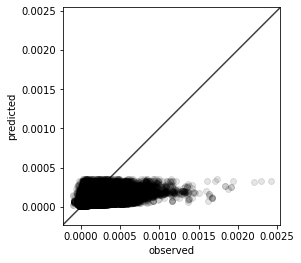

In [218]:
# Resubstitution error
print('Resubstitution MAE:', round(metrics.mean_absolute_error(train_y, pred_y), 2))
print('Resubstitution RMSE:', round(np.sqrt(metrics.mean_squared_error(train_y, pred_y)), 2))
print('Resubstitution R2:', round(metrics.r2_score(train_y, pred_y), 3))

fig, ax = plt.subplots()
ax.scatter(train_y, pred_y, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()

Cross-validated error:

In [219]:
# Cross-validated error (each daytime in a separate fold to emulate a new observation)
groups = np.array(train_df['datehour'])
group_kfold = GroupKFold(n_splits=10)
group_kfold.get_n_splits(train_X, train_y, groups)

alltest_CV = np.empty((0,1), float)
allpreds_CV = np.empty((0,1), float)
allindx_CV = np.empty((0,1), float)

MAE_CV=[]
RMSE_CV=[]
R2_CV=[]
for train_index, test_index in group_kfold.split(train_X, train_y, groups):
    train_X_CV, test_X_CV = train_X[train_index], train_X[test_index]
    train_y_CV, test_y_CV = train_y[train_index], train_y[test_index]
    rf.fit(train_X_CV, train_y_CV)
    pred_y_CV = rf.predict(test_X_CV)
    alltest_CV = np.append(alltest_CV, test_y_CV)
    allpreds_CV = np.append(allpreds_CV, pred_y_CV)
    allindx_CV =  np.append(allindx_CV, train_index)
    MAE_CV.append(round(metrics.mean_absolute_error(test_y_CV, pred_y_CV), 2))
    RMSE_CV.append(round(np.sqrt(metrics.mean_squared_error(test_y_CV, pred_y_CV)), 2))
    R2_CV.append(round(metrics.r2_score(test_y_CV, pred_y_CV), 3))

CV MAE: 0.0
CV RMSE: 0.0
CV R2: 0.17


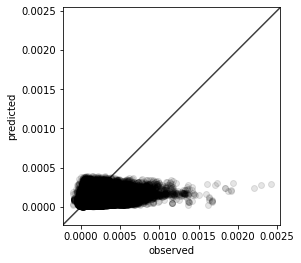

In [220]:
# Metrics
print('CV MAE:', round(statistics.mean(MAE_CV), 2))
print('CV RMSE:', round(statistics.mean(RMSE_CV), 2))
print('CV R2:', round(statistics.mean(R2_CV), 2))

fig, ax = plt.subplots()
ax.scatter(alltest_CV, allpreds_CV, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()

## Model Validation

Create target grid for the AOI (1 km)

In [272]:
## Not important - just for testing
from sentinelhub import bbox_to_dimensions, bbox_to_resolution,to_utm_bbox

bounds_down = list(s5p_eop.bbox)
print(bounds_down)

#
b = to_utm_bbox(s5p_eop.bbox)

print(b)
res_down = bbox_to_dimensions(b, 1000)
print(res_down)


[26.677331470947365, -27.758826442871097, 31.51909147094736, -23.35722644287111]
468203.967009899,6929471.492104915,962226.5501804517,7409697.311010616
(494, 480)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()


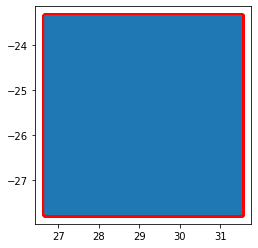

In [261]:
# Prepare grid
bounds_down = list(s5p_eop.bbox)
res_down = bbox_to_dimensions(s5p_eop.bbox, 1000)

x_res_down = (bounds_down[2]-bounds_down[0])/res_down[0]
y_res_down = (bounds_down[3]-bounds_down[1])/res_down[1]

bounds_down = geometry.box(bounds_down[0], bounds_down[1], bounds_down[2], bounds_down[3])
bounds_down = gpd.GeoDataFrame({"id":1,"geometry":[bounds_down]}, crs="EPSG:4326")
s5p_grid_down = recpolygrid(bounds_down, x_res_down,y_res_down, 4326)
s5p_centroids_down = gpd.GeoDataFrame(geometry= s5p_grid_down.centroid)

#del s5p_eop

# Show it
p = s5p_grid_down.boundary.plot()
s5p_centroids_down.plot(ax=p, color='red')
plt.show()


### Extract predictor data at target grid for the AOI (1 km)

#### Prepare DEM with 1km NO2

In [274]:
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                            filename='NO2_DEM_1km.tif',
                           no_data_value=128)
dem_train_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(494, 480, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((26.56263888888889, -28.18263888888889), (31.747083333333336, -23.24763888888889)), crs=CRS('4326'))
  timestamp: []
)

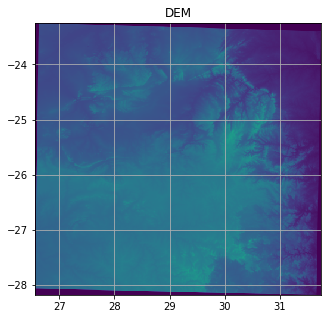

In [275]:
fig, ax = plt.subplots(figsize=(6,5))

draw_feature(ax=ax, eopatch=dem_train_eop, 
             feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
             vmin=0, vmax=4000, cmap=plt.cm.viridis, time_idx=None)


In [276]:
# Perform zonal statistics - mean altitude per CAMS pixel
src = rio.open(str(dem_train_dir) + '/NO2_DEM_1km.tif')
affine = src.transform
array = dem_train_eop.data_timeless['DEM']
array = array[:, :, 0]
dem_grid_1km = s5p_grid_down
zstats = zonal_stats(dem_grid_1km, array, affine=affine, stats="mean", nodata=np.nan)
vals = []
for index, value in enumerate(zstats):
    vals.append(value['mean'])
    
dem_grid_1km['elevation'] = vals

In [277]:
# Now we can rasterize
minx, miny, maxx, maxy = s5p_grid_down.geometry.total_bounds
sizey = round((maxy-miny)/y_res_down)
sizex = round((maxx-minx)/x_res_down)
transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
shapes = ((geom, value) for geom, value in zip(dem_grid_1km.geometry, dem_grid_1km['elevation']))

dem1km = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
dem1km
export_geotiff(str(dem_train_dir) + '/DEM_NO2_1km.tif', dem1km, transform, 4326)

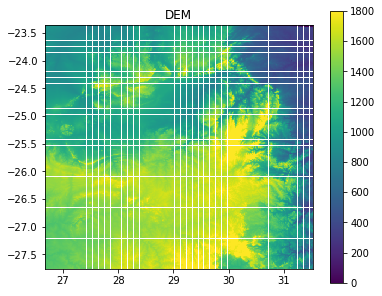

In [279]:
# Read and visualize
dem_val_dir = DATA_DIR/AOIS[0]/'DEM'
dem_val_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                           filename='DEM_NO2_1km.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_val_eop,
                  feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                  time_idx=None,
                  vmin=0, vmax=1800)
#pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);

draw_feature(ax=ax, eopatch=dem_val_eop, 
             feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
             vmin=0, vmax=1800, cmap=plt.cm.viridis, time_idx=None)

## Prediction

In [236]:
bbox_sa = gpd.read_file('AOIs_bboxes/South_Africa/South_Africa_test.shp')

In [239]:
cams_pm25_test_dir = Path('validation_dataset_south_africa/South_Africa/sentinel5P/NO2')
dates_sa_no2 = pd.read_csv('submission_date/SA-date-NO2.txt')
dates_sa_no2

,Day,time
0,2150,h10
1,2153,h11
2,2161,h11
3,2170,h10
4,2178,h11
5,2180,h10
6,2186,h10
7,2190,h11
8,2196,h10
9,2200,h11


In [44]:
day, time = dates_sa_pm25.iloc[0]

In [243]:
## Prepare the test images
input_filenames = []
for index in dates_sa_no2.index:
    day, time = dates_sa_no2.iloc[index]
    input_filename = f'S5P_NO2__OFFL_L2_day{day}_T{time.split("h")[-1]}.tif'
    input_filenames.append(input_filename)

input_filenames

['S5P_NO2__OFFL_L2_day2150_T10.tif',
 'S5P_NO2__OFFL_L2_day2153_T11.tif',
 'S5P_NO2__OFFL_L2_day2161_T11.tif',
 'S5P_NO2__OFFL_L2_day2170_T10.tif',
 'S5P_NO2__OFFL_L2_day2178_T11.tif',
 'S5P_NO2__OFFL_L2_day2180_T10.tif',
 'S5P_NO2__OFFL_L2_day2186_T10.tif',
 'S5P_NO2__OFFL_L2_day2190_T11.tif',
 'S5P_NO2__OFFL_L2_day2196_T10.tif',
 'S5P_NO2__OFFL_L2_day2200_T11.tif']

#### Extract DEM


In [247]:
# Extract DEM
raster_path = [(str(dem_val_dir) + '/DEM_NO2_1km.tif')]
dem_1km_df = extract_points_from_raster(s5p_centroids_down, raster_path, 'DEM')
dem_1km_df = pd.concat(dem_1km_df)

dem_1km_df = dem_1km_df.dropna()
dem_1km_df = dem_1km_df.drop('raster', 1)

In [248]:
dem_1km_df

,lon,lat,DEM
0,26.682232,-23.361811,933.363037
1,26.682232,-23.370981,932.309021
2,26.682232,-23.380151,930.875000
3,26.682232,-23.389321,934.575745
4,26.682232,-23.398491,946.461182
...,...,...,...
237115,31.514191,-27.717561,779.795471
237116,31.514191,-27.726731,726.019043
237117,31.514191,-27.735901,712.352783
237118,31.514191,-27.745071,698.902527


In [253]:
## Create submission file

submission_dir = Path('test-submission')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(submission_dir/aoi/product):
            os.makedirs(submission_dir/aoi/product)
            
visulize_dir = Path('test-visulize')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(visulize_dir/aoi/product):
            os.makedirs(visulize_dir/aoi/product)

#### Predict UPSCALED NO2 VALUES 

In [255]:

bbox_sa.to_crs(epsg=4326, inplace=True)
bbox_sa.to_file('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', driver='ESRI Shapefile')

test_df = dem_1km_df

for input_filename in input_filenames:
    test_df['day']=np.nan
    test_df['hour']=np.nan
    test_df['datehour']=""
    
    for i in range(test_df.shape[0]):
        tiff_name = input_filename
        day, hour = tiff_name.split('_day')[-1].split('_')
        test_df.iat[i,test_df.columns.get_loc('day')] = day
        test_df.iat[i,test_df.columns.get_loc('hour')] = hour[1:3]
        test_df.iat[i,test_df.columns.get_loc('datehour')] = str(day)+str(hour[1:3])
        

    # X inputs
    test_X = np.array(test_df.drop(['day','datehour'], axis=1))
    
    ## PREDICTION
    predicted_NO2 = rf.predict(test_X)
    
    #test_df['predicted_CAMS'] = predicted_CAMS
    
    ## rastrize
    minx, miny, maxx, maxy = s5p_grid_down.geometry.total_bounds
    sizey = round((maxy-miny)/y_res_down)
    sizex = round((maxx-minx)/x_res_down)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(s5p_grid_down.geometry, predicted_NO2))
    upscaled_PM_2_5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    
    ## export for prediction
    export_geotiff(str(submission_dir) + '/South_Africa/NO2/'+f'{day}_NO2_South_Africa.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', 
              submission_dir/'South_Africa'/'NO2'/f'{day}_NO2_South_Africa.tif', 
              submission_dir/'South_Africa'/'NO2'/f'{day}_NO2_South_Africa.tif')
    
    ## export them for visualization 
    export_geotiff(str(visulize_dir) + '/South_Africa/NO2/'+f'S5P_NO2__OFFL_L2_day{day}_T{hour[1:3]}.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', 
              visulize_dir/'South_Africa'/'NO2'/f'S5P_NO2__OFFL_L2_day{day}_T{hour[1:3]}.tif', 
              visulize_dir/'South_Africa'/'NO2'/f'S5P_NO2__OFFL_L2_day{day}_T{hour[1:3]}.tif')
    
    #S5P_NO2__OFFL_L2_day2150_T10.tif

    

In [259]:
## load upscaled NO2
upscaled_s5p_dir = Path('test-visulize/South_Africa/NO2')
upscaled_no2_img = load_tiffs(upscaled_s5p_dir,
                          (FeatureType.DATA, 'NO2'),
                              offset=OFFSET)

#s5p_train_dir = DATA_DIR/AOIS[0]/'filtered_sentinel5P'

#s5p_eop = load_tiffs(s5p_train_dir/'filtered_NO2', (FeatureType.DATA, 'NO2'), offset=OFFSET) 

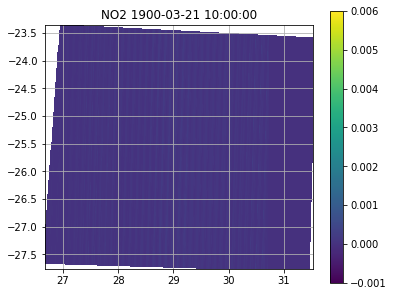

In [260]:
# Plot upscaled NO2
fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=upscaled_no2_img, 
                 feature=(FeatureType.DATA, 'NO2'),
                 time_idx=5, 
                 vmin=-0.001, vmax=0.006)
fig.colorbar(fh, ax=ax);